# WFC3 Figure-8 Ghost Classification using Convolutional Neural Networks (CNNs)
---

The purpose of the notebook is to demonstrate how to use a DeepWFC3 model to predict if a WFC3 image contains a figure-8 ghost. These models are fully described in [WFC3-ISR 2022-03](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2022/WFC3-ISR-2022-03.pdf).

## Imports <a id="imports"></a>

If you are running this notebook in Jupyter, this notebook assumes you created the virtual environment defined in `environment.yml`. If not, close this notebook and run the following lines in a terminal window:

`conda env create -f environment.yml`

`conda activate deepwfc3_env`

We import the following libraries:
- *numpy* for handling arrays
- *matplotlib* for plotting
- *torch* as our machine learning framework

We also import functions from various model `utils.py` to load the models. In addition, `model_a_utils.py` has functions to further process images and produce saliency maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import transforms

from model_a.model_a_utils import process_image, load_wfc3_fig8_model_a, saliency_map
from model_b.model_b_utils import load_wfc3_fig8_model_b
from model_c.model_c_utils import load_wfc3_fig8_model_c
from model_d.model_d_utils import load_wfc3_fig8_model_d
from model_syn.model_syn_utils import load_wfc3_fig8_model_syn

## Load Data

`examples.npz` is a compressed numpy file containing two WFC3 images post processing pipeline (see `process_uvis_image.py`). The first image is a null image of the galaxy N5643 (idgg69pmq) and the second is the globular cluster NGC-6752 (ibhf01sjq), which contains a figure-8 ghost.

We load the images using `np.load()` and transform them to `torch.Tensor` objects.

In [2]:
example_0, example_1 = np.load('examples.npz')['examples']

example_0_torch = torch.Tensor(example_0.reshape(1,1,256,256))
example_1_torch = torch.Tensor(example_1.reshape(1,1,256,256))

## Scale Data to ImageNet 

Since Model A was pretrained using [ImageNet](https://www.image-net.org/), we need to scale our examples to match the statistics of the dataset. We do this by:
- min-max scaling the images to have a minimum/maximum pixel value of 0/1
- making three copies of our examples to use as "RGB channels"
- center cropping to a 224x224
- normalizing the channels to $N(\mu=(0.485, 0.456, 0.406), \sigma=(0.229, 0.224, 0.225))$

See some [documentation](https://pytorch.org/hub/pytorch_vision_googlenet/) for more information.

In [3]:
example_0_process = process_image(example_0)
example_1_process = process_image(example_1)

## Load Models

We load the five models described in the [WFC3-ISR 2022-03](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2022/WFC3-ISR-2022-03.pdf). Here are their brief descriptions:

- Model A uses the [GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) architecture
- Model B uses 3 convolutional layers and 4 fully connected layers
- Model C uses 3 convolutional layers and 3 fully connected layers
- Model D uses 3 convolutional layers and 4 fully connected layers
- Model Syn uses 2 convolutional layers and 3 fully connected layers (LeNet architecture)

The model is saved as `wfc3_fig8_model_{name}.torch` and can be loaded using `load_wfc3_fig8_model_{name}()`.

In [4]:
model_a = load_wfc3_fig8_model_a('model_a/wfc3_fig8_model_a.torch')
model_b = load_wfc3_fig8_model_b('model_b/wfc3_fig8_model_b.torch')
model_c = load_wfc3_fig8_model_c('model_c/wfc3_fig8_model_c.torch')
model_d = load_wfc3_fig8_model_d('model_d/wfc3_fig8_model_d.torch')
model_syn = load_wfc3_fig8_model_syn('model_syn/wfc3_fig8_model_syn.torch')

## Predict Examples

To predict the example classifications, we use them as arguments for the models, which returns the last two output neurons.

In [5]:
# Model A
pred_0_a = model_a(example_0_process)
pred_1_a = model_a(example_1_process)

# Model B
pred_0_b = model_b(example_0_torch)
pred_1_b = model_b(example_1_torch)

# Model C
pred_0_c = model_c(example_0_torch)
pred_1_c = model_c(example_1_torch)

# Model D
pred_0_d = model_d(example_0_torch)
pred_1_d = model_d(example_1_torch)

# Model Syn
pred_0_syn = model_syn(example_0_torch)
pred_1_syn = model_syn(example_1_torch)

The index of the greatest neuron output is the prediction, e.g. [-3, 2] would be classified as having a figure-8 ghost.

In [6]:
print ('Model A Results:')
print ('Example 0 Model A Output Neurons: {}'.format(pred_0_a))
print ('Example 1 Model A Output Neurons: {}'.format(pred_1_a))
print ('')

print ('Model B Results:')
print ('Example 0 Model B Output Neurons: {}'.format(pred_0_b))
print ('Example 1 Model B Output Neurons: {}'.format(pred_1_b))
print ('')

print ('Model C Results:')
print ('Example 0 Model C Output Neurons: {}'.format(pred_0_c))
print ('Example 1 Model C Output Neurons: {}'.format(pred_1_c))
print ('')

print ('Model D Results:')
print ('Example 0 Model D Output Neurons: {}'.format(pred_0_d))
print ('Example 1 Model D Output Neurons: {}'.format(pred_1_d))
print ('')

print ('Model Syn Results:')
print ('Example 0 Model Syn Output Neurons: {}'.format(pred_0_syn))
print ('Example 1 Model Syn Output Neurons: {}'.format(pred_1_syn))
print ('')

Model A Results:
Example 0 Model A Output Neurons: tensor([[ 1.5189, -1.7295]], grad_fn=<AddmmBackward>)
Example 1 Model A Output Neurons: tensor([[-2.7610,  2.8238]], grad_fn=<AddmmBackward>)

Model B Results:
Example 0 Model B Output Neurons: tensor([[ 1.5637, -1.8389]], grad_fn=<AddmmBackward>)
Example 1 Model B Output Neurons: tensor([[-3.9928,  9.7570]], grad_fn=<AddmmBackward>)

Model C Results:
Example 0 Model C Output Neurons: tensor([[-0.0573, -4.6405]])
Example 1 Model C Output Neurons: tensor([[-11.1430,   4.4422]])

Model D Results:
Example 0 Model D Output Neurons: tensor([[ 0.0233, -0.1296]], grad_fn=<AddmmBackward>)
Example 1 Model D Output Neurons: tensor([[-0.2992,  4.5533]], grad_fn=<AddmmBackward>)

Model Syn Results:
Example 0 Model Syn Output Neurons: tensor([[ 1.7655, -1.4126]], grad_fn=<AddmmBackward>)
Example 1 Model Syn Output Neurons: tensor([[-2.6848,  3.2520]], grad_fn=<AddmmBackward>)



## View Saliency Maps

We can view the [saliency maps](https://arxiv.org/pdf/1312.6034.pdf) our models produce for the examples by using `saliency_map()`, which prints the prediction probabilities, and plots the original image and the saliency map.

Model A
Null Probability: 0.9626
Figure-8 Probability: 0.0374
Prediction: 0


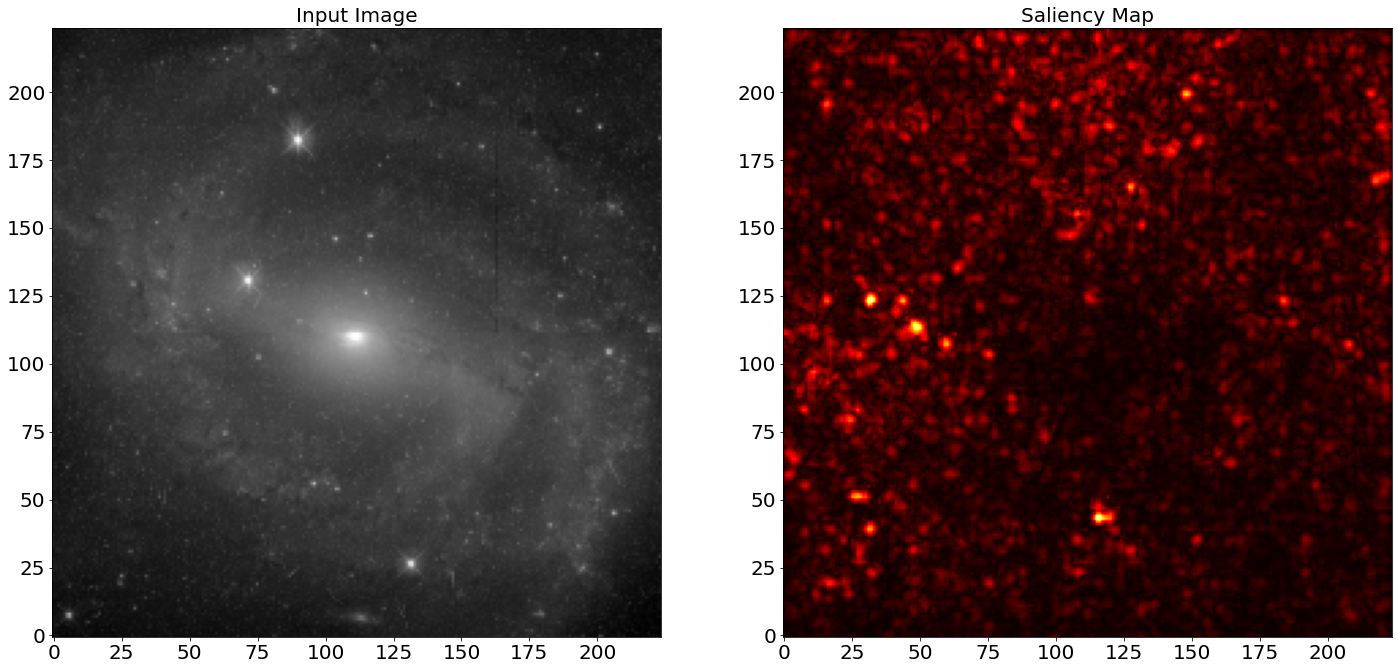

Null Probability: 0.0037
Figure-8 Probability: 0.9963
Prediction: 1


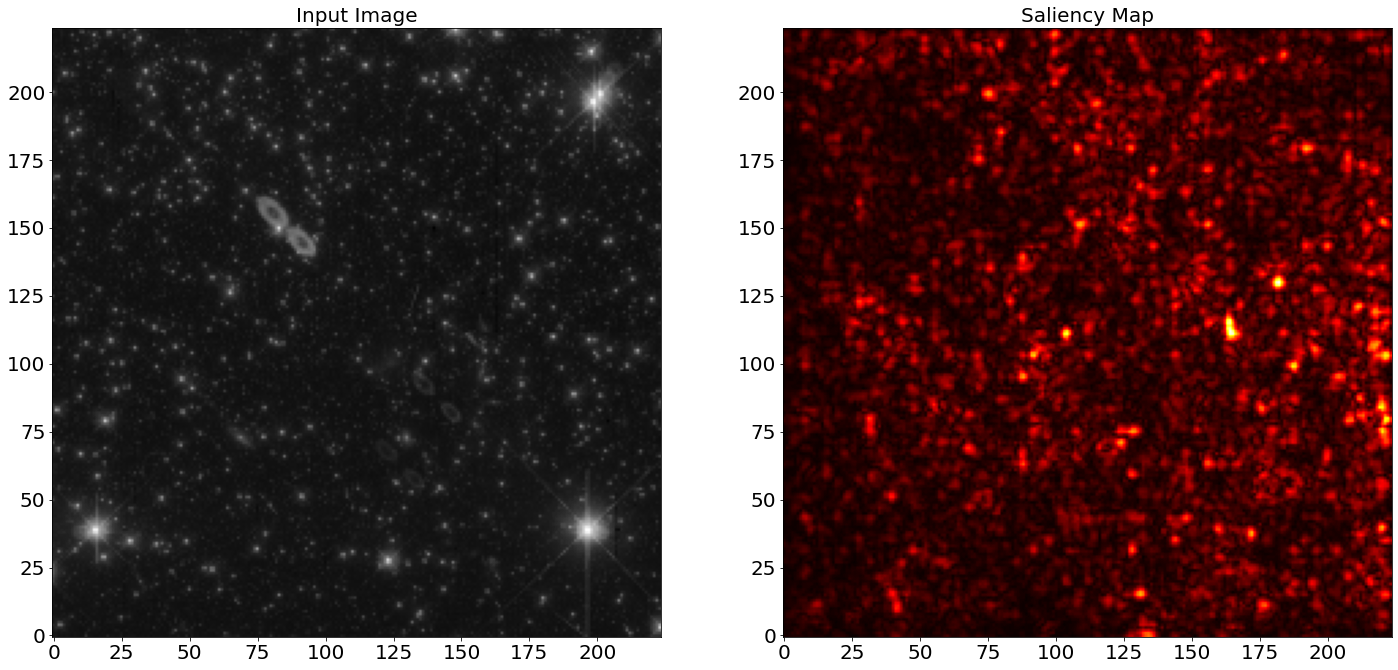

#######################################
Model B
Null Probability: 0.9678
Figure-8 Probability: 0.0322
Prediction: 0


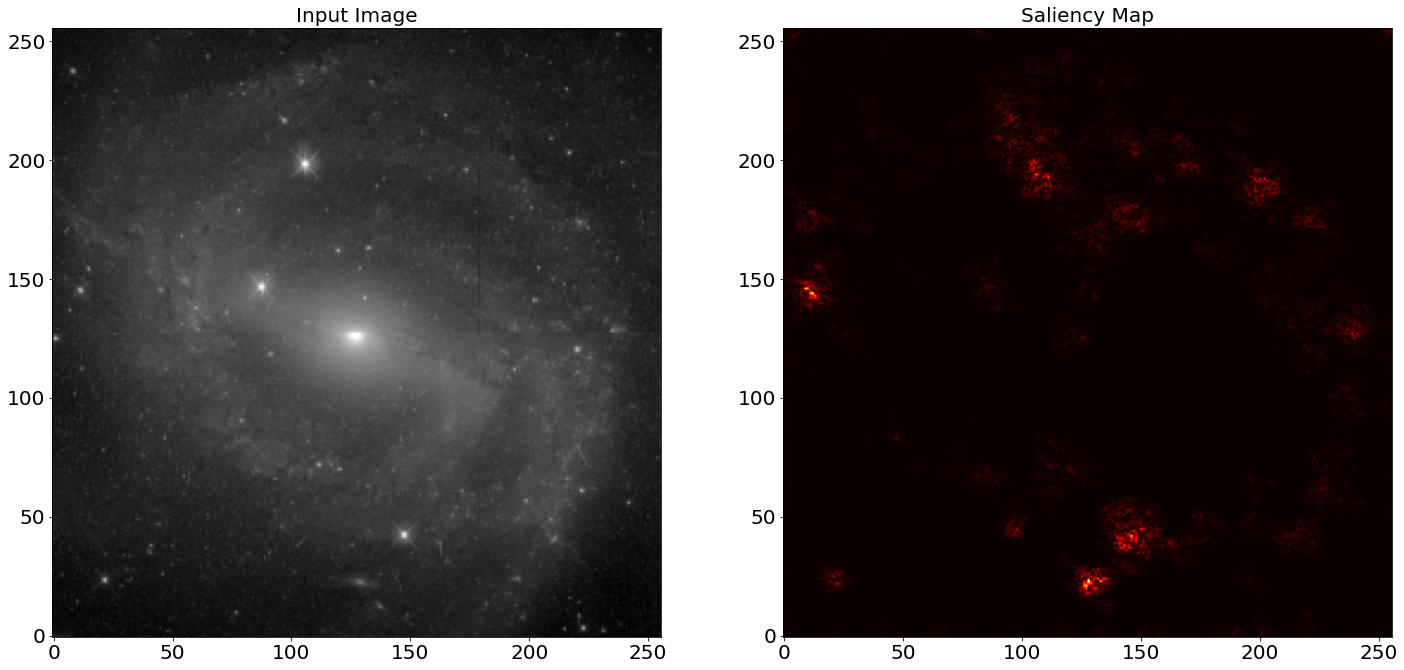

Null Probability: 0.0000
Figure-8 Probability: 1.0000
Prediction: 1


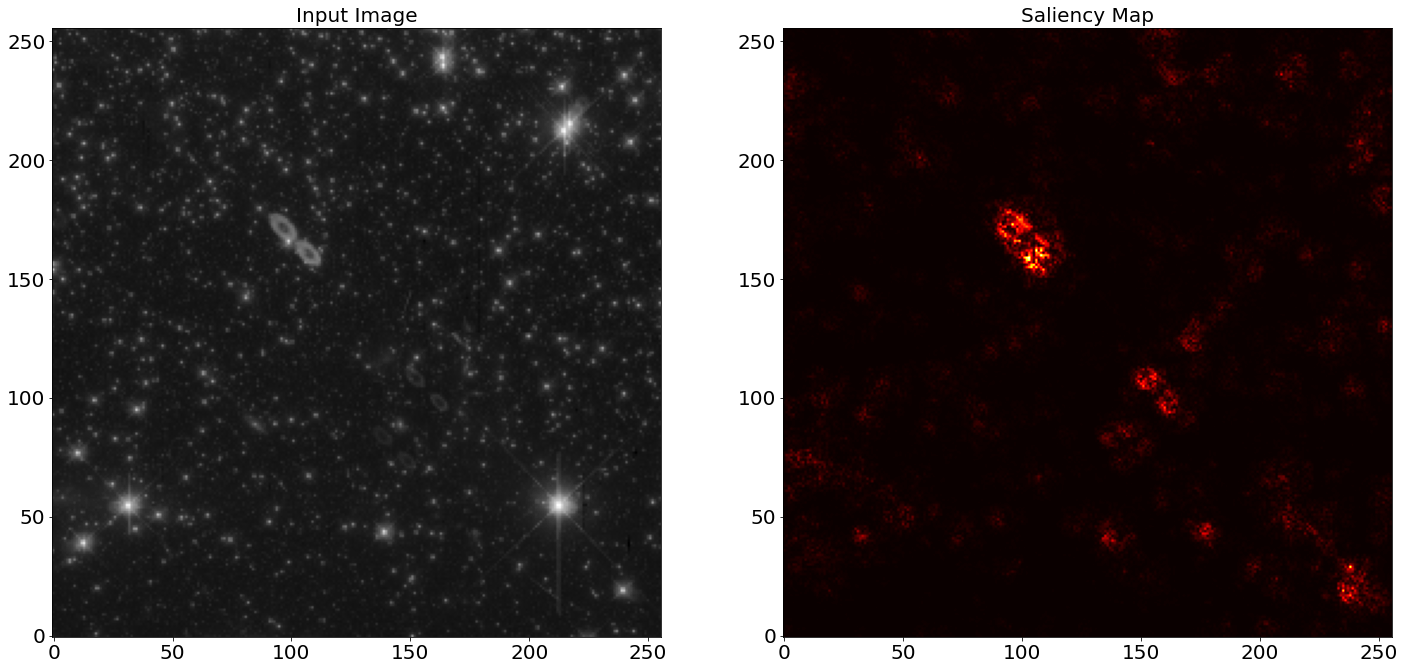

#######################################
Model C
Null Probability: 0.9899
Figure-8 Probability: 0.0101
Prediction: 0


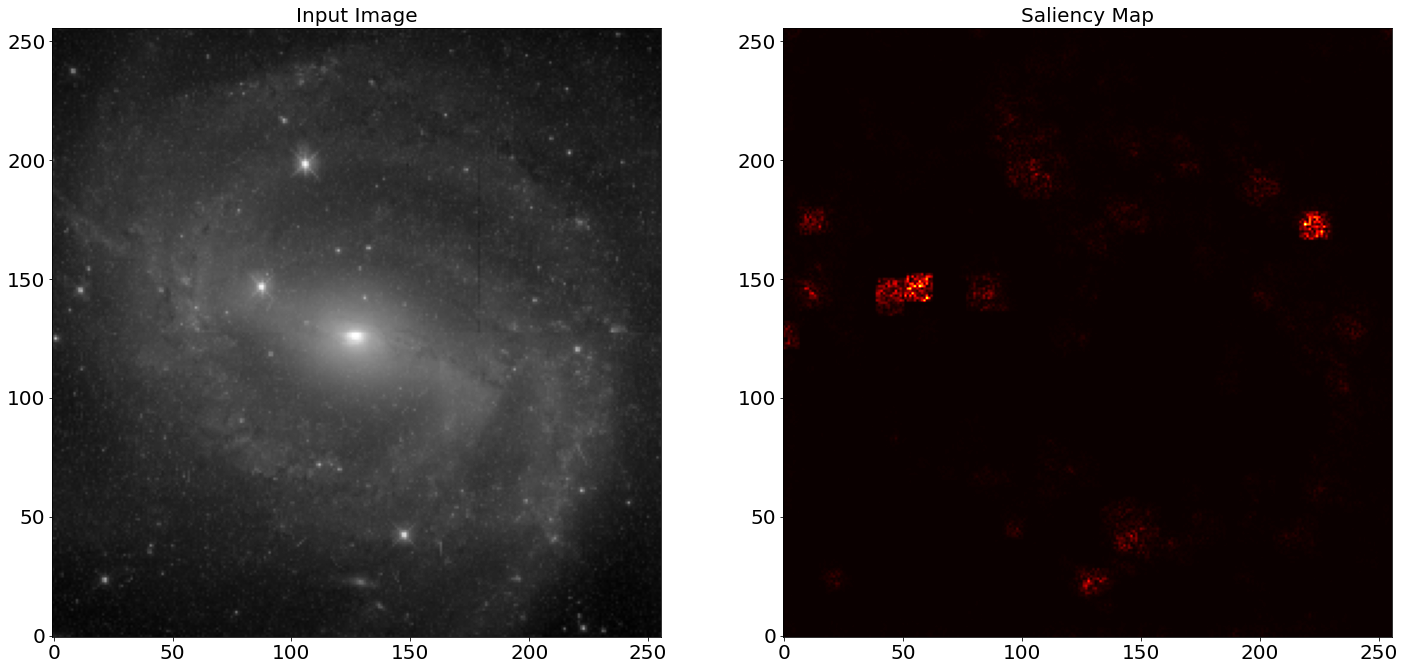

Null Probability: 0.0000
Figure-8 Probability: 1.0000
Prediction: 1


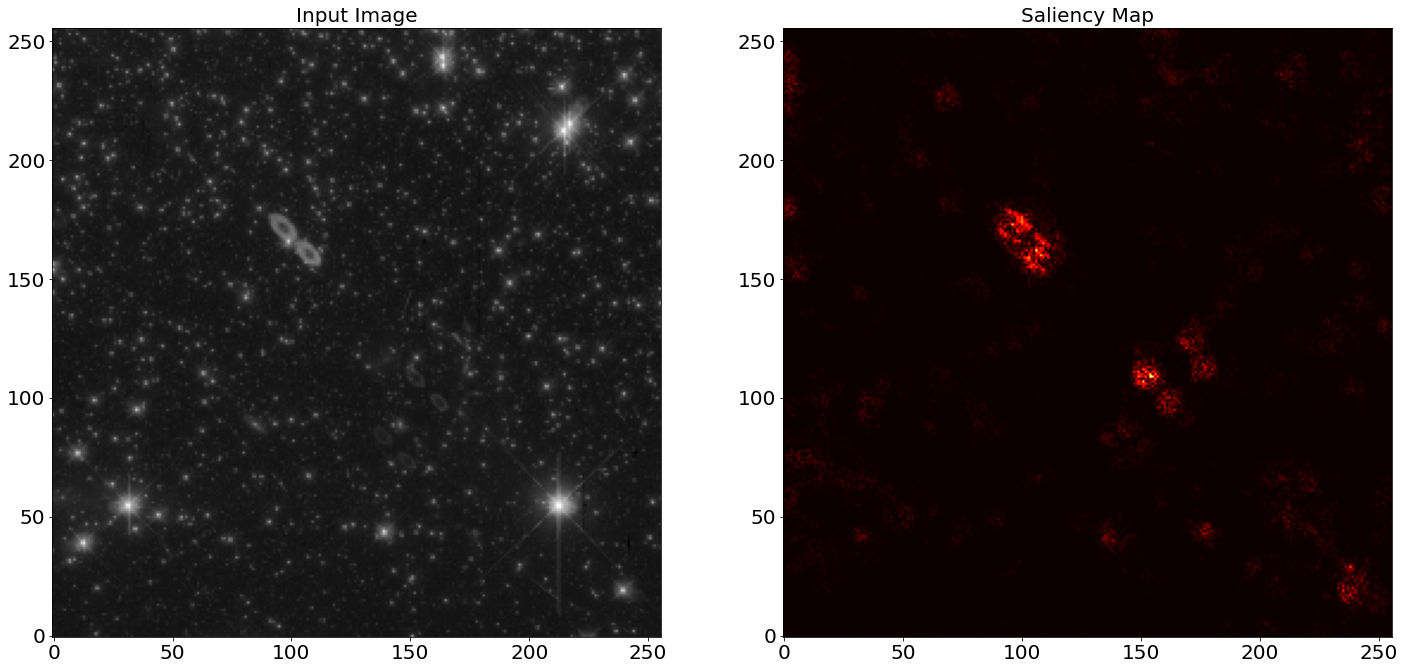

#######################################
Model D
Null Probability: 0.5382
Figure-8 Probability: 0.4618
Prediction: 0


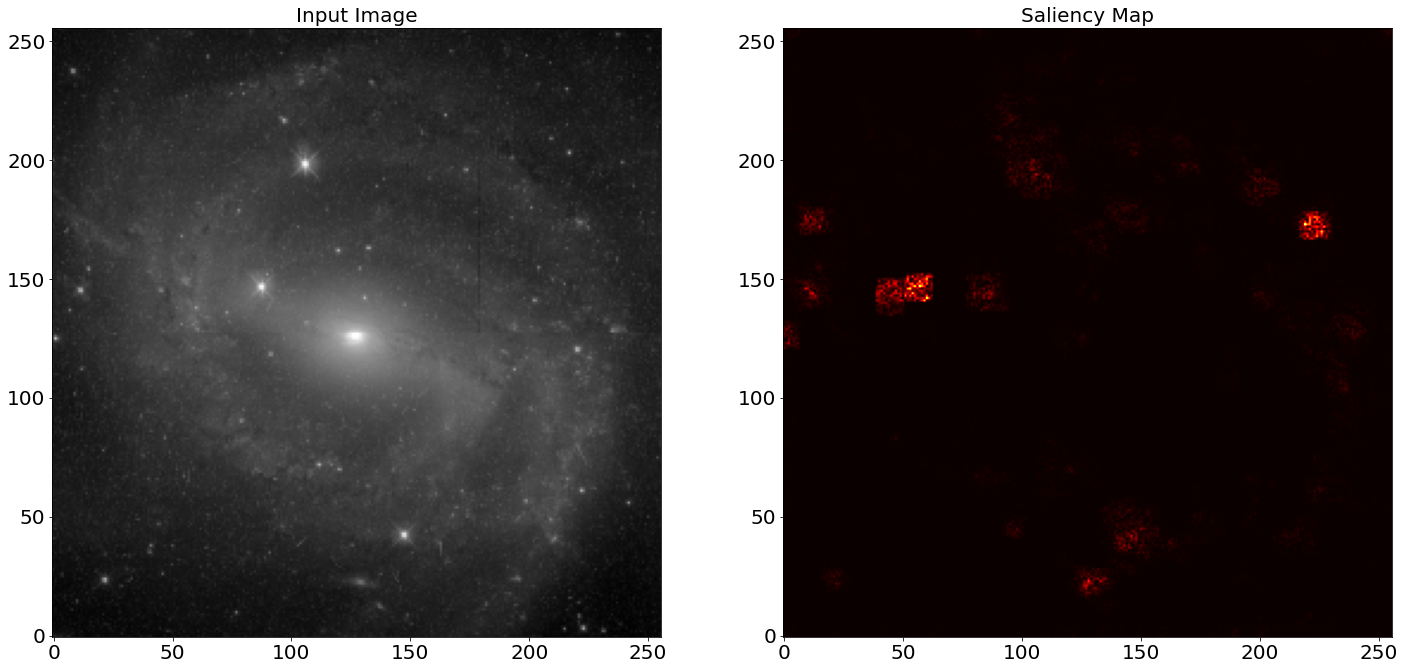

Null Probability: 0.0077
Figure-8 Probability: 0.9923
Prediction: 1


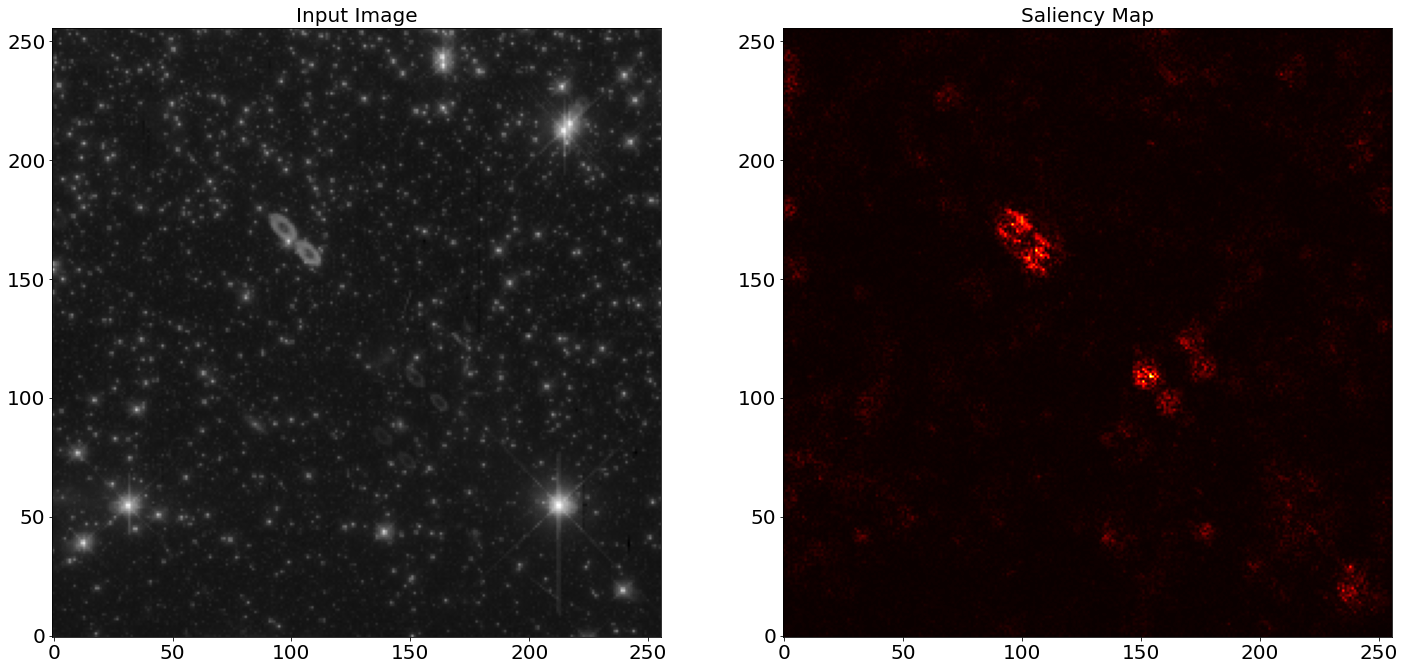

#######################################
Model Syn
Null Probability: 0.9600
Figure-8 Probability: 0.0400
Prediction: 0


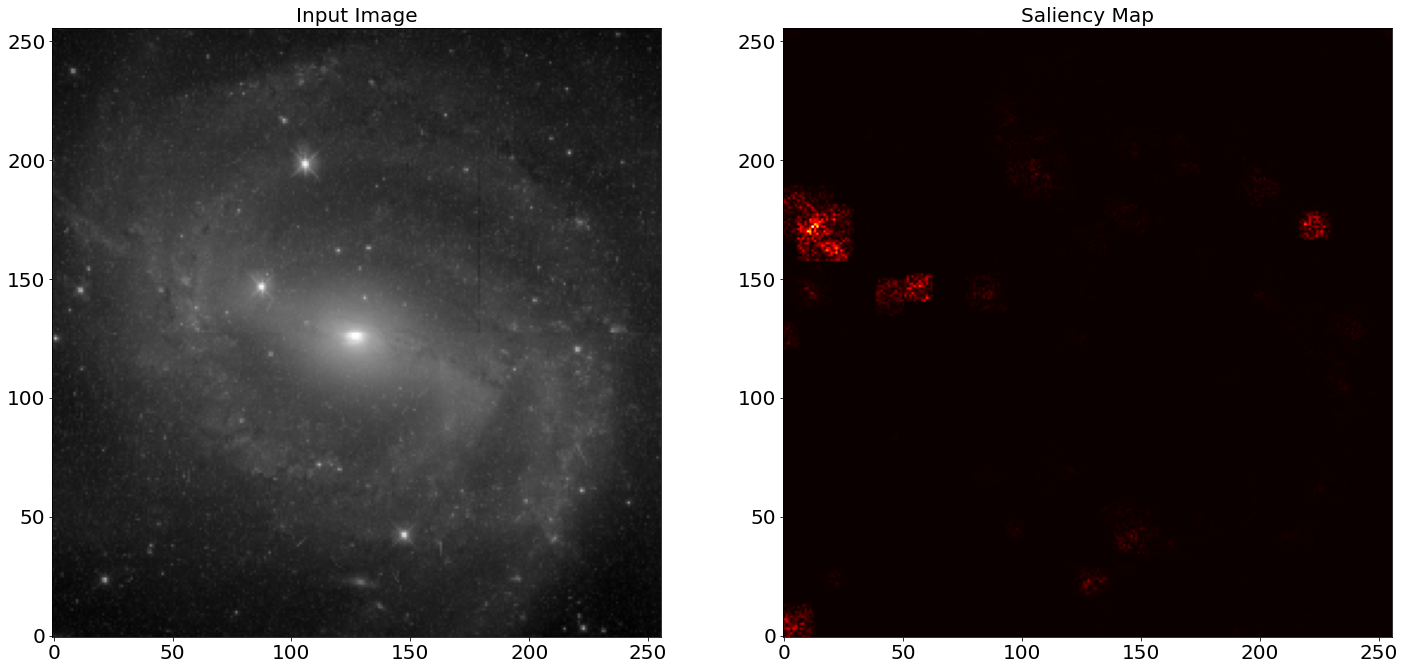

Null Probability: 0.0026
Figure-8 Probability: 0.9974
Prediction: 1


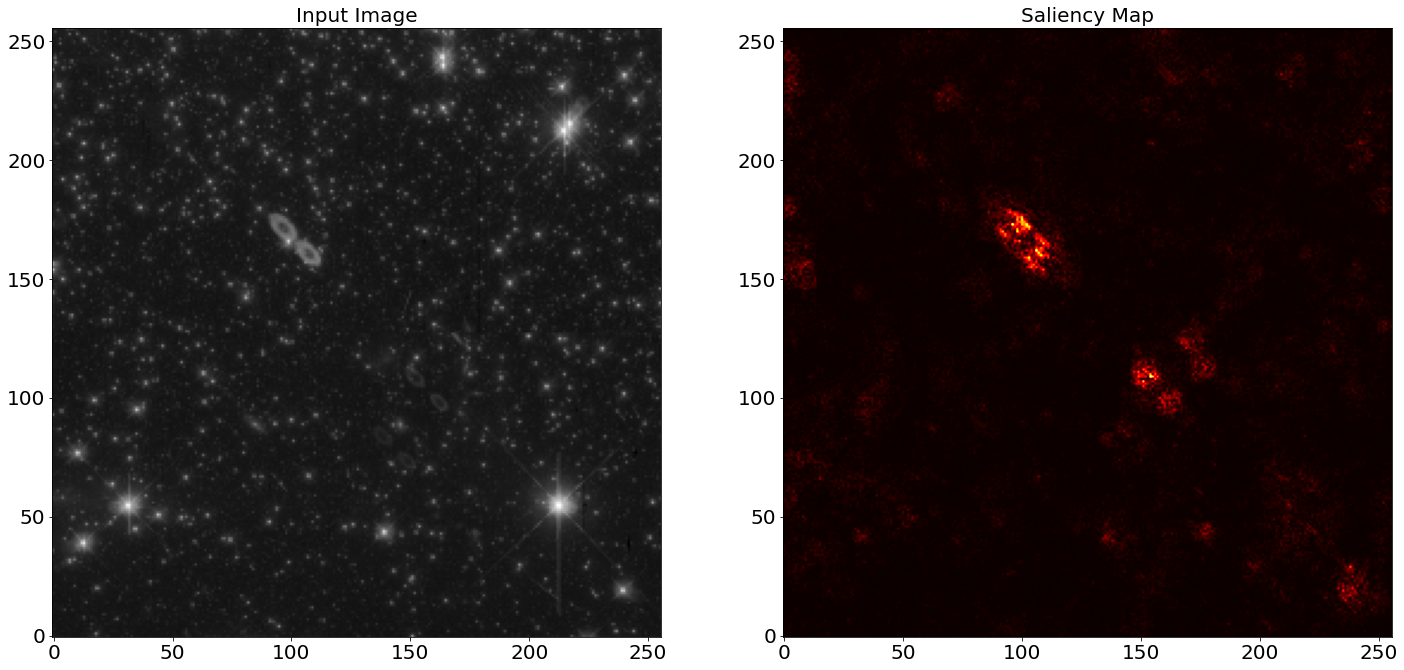

#######################################


In [7]:
# Model A
print ('Model A')
sm_0_a = saliency_map(model_a, example_0_process)
sm_1_a = saliency_map(model_a, example_1_process)
print ('#######################################')

# Model B
print ('Model B')
sm_0_b = saliency_map(model_b, example_0_torch)
sm_1_b = saliency_map(model_b, example_1_torch)
print ('#######################################')

# Model C
print ('Model C')
sm_0_c = saliency_map(model_c, example_0_torch)
sm_1_c = saliency_map(model_c, example_1_torch)
print ('#######################################')

# Model D
print ('Model D')
sm_0_d = saliency_map(model_d, example_0_torch)
sm_1_d = saliency_map(model_d, example_1_torch)
print ('#######################################')

# Model Syn
print ('Model Syn')
sm_0_syn = saliency_map(model_syn, example_0_torch)
sm_1_syn = saliency_map(model_syn, example_1_torch)
print ('#######################################')

In [10]:
path = '/Users/fdauphin/Desktop/WFC3/MLG/projects/uvis_fig_8/notebooks/explore/test2022.npz'
x = np.load(path)['samp']

In [12]:
x_torch = torch.Tensor(x.reshape(1,1,256,256))

In [14]:
x_process = process_image(x_torch)

Null Probability: 0.8634
Figure-8 Probability: 0.1366
Prediction: 0


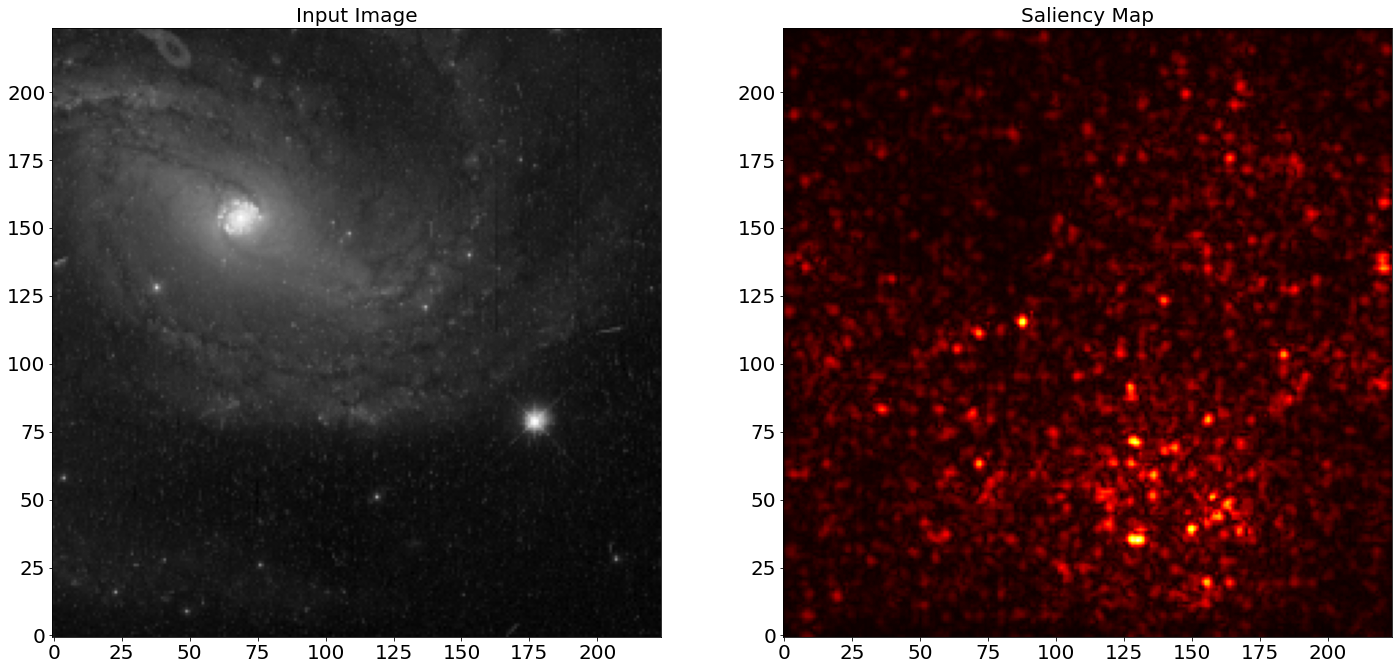

In [23]:
sm_x = saliency_map(model_a, x_process)

## Conclusions <a id="con"></a>

Thank you for walking through this notebook. Now you should be more familiar with using our models to predict if figure-8 ghosts are on WFC3 images.

## About this Notebook <a id="about"></a>

**Author:** DeepWFC3 team: Fred Dauphin, Mireia Montes, Nilufar Easmin, Varun Bajaj, Peter McCullough

**Updated on:** 2022-03-07

## Citations <a id="cite"></a>

If you use `numpy`, `matplotlib`, or `torch` for published research, please cite the authors. Follow these links for more information about citing `numpy`, `matplotlib`, and `torch`:

* [Citing `numpy`](https://numpy.org/doc/stable/license.html)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/license.html#:~:text=Matplotlib%20only%20uses%20BSD%20compatible,are%20acceptable%20in%20matplotlib%20toolkits.)
* [Citing `torch`](https://github.com/pytorch/pytorch/blob/master/LICENSE)